In [1]:
import glob
import pickle
import datetime
import string
import statistics
import pandas as pd
import seaborn as sns
import math
import numpy as np
import re
from  datetime import timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
plt.style.use("classic")
import spacy
spacy.load('en')
from spacy.lang.en import English
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
en_stop = set(nltk.corpus.stopwords.words('english'))
sns.set()

In [2]:
def get_mail(file):
    '''
    returns the dictionary with email date, recipients, indirect recipients, sender, body of email 
    '''
    monthDict = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 
            'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
    mail = {'recipient':[],"indirect":[]}
    mesg = ''
    found = False
    found_to = False
    found_cc = False
    consec = 0
    for idx,i in enumerate(file.readlines()):
#        print(idx,i)
        if i == "\n":
            consec += 1
        else:
            consec = 0
            
        if consec >= 2:
            break
            
        i = i.strip()
        
        if idx == 1:
            date = i.split(":")[1].split(",")[1].strip()
            date = date.split()[:-1]
            day = int(date[0])
            month = monthDict[date[1]]
            year = int(date[2])
            date = "{}-{}-{}".format(year,month,day)
            mail["date"] = datetime.datetime.strptime(date,'%Y-%m-%d')
            
        elif idx == 2:
            mail["sender"] = i.split(":")[1].strip()
        
        if i.startswith("To:"):
            found_to = True
            
        if i.startswith("Cc:"):
            found_cc = True
            
        if i.startswith("Mime-Version:"):
            found_cc = False
            
        if i.startswith("Subject:"):
            found_to = False
        if found_cc:
            rec = i.replace("Cc:","").replace(",","").split()
#             print(rec)
            for r in rec:
                mail['indirect'].append(r)
            
            
        if found_to:
#             print(i)
            rec = i.replace("To: ","").replace(",","").split()
#             print(rec)
            for r in rec:
                mail['recipient'].append(r)
            
        if i.startswith("X-FileName:"):
            found = True
            continue
        
        if found and i != "":
            if i[0] == '"' or i[0] == "-":
                break
            else:
                mesg += (i + "\n") 
                
    mail["message"] = mesg.strip()
    
    return mail
            

# translator for removing punctuations           
translator = str.maketrans("","",string.punctuation)
def get_characters(msg):
    '''
    returns the length of characters in a message body of email
    '''
    msg = msg.replace("\n","")
    msg = msg.replace(" ","")
    msg = msg.translate(translator)
    return len(msg)

def get_recipients(res):
    '''
    get count of recipients
    '''
    return len(res)

def get_total_recipients(res, ind):
    '''
    get count of total recipients
    '''
    return(len(res) + len(ind))
    
def filter_mail(mail):
    '''
    checks the date of email along with maximum characters in the email.
    returns true if email is valid and false otherwise
    '''
    
    msg = mail["message"]
    res = mail["recipient"]
    ind = mail["indirect"]
    
    c1 = False
    c2 = False
    
    ch = get_characters(msg)
    re = get_recipients(res)
    inre = get_recipients(ind)
    retotal = get_total_recipients(res, ind)
    d1 = datetime.datetime.strptime("2000-01-01",'%Y-%m-%d') 
    d2 = datetime.datetime.strptime("2001-12-31",'%Y-%m-%d') 
    date = mail["date"]
    
    if ch <= 3000 and re <= 20 and inre <= 20 and retotal <= 20:
        c1 = True
    
    if date >= d1 and date <= d2:
        c2 = True
        
#     print(ch,date)

    if c1 and c2:
        return True
    else:
        return False

    
def get_stat(arr):   
    '''
    returns maximum,minimum,mean,median of the numpy array
    '''
    minimum = min(arr)
    maximum = max(arr)
    mean = statistics.mean(arr)
    median = statistics.median(arr)
    
    return maximum,minimum,mean,median


def get_net_sentiment(msg):
    '''
    return the net sentiment of the message
    '''
    p = 0
    n = 0
    msg = msg.split()
    for word in msg:
        if word in pos:
            p += 1
        if word in neg:
            n += 1
            
    if (n+p) != 0:
        sent = (p-n)/(p+n)
        return sent
    else:
        return 0
    
    
def get_disagreement(msg):
    '''
    returns the disagreement of the message
    '''
    return 1 - get_net_sentiment(msg)

def get_post_neg():
    
    '''
    returns the positive and negative words lists from LoughranMcDonald_SentimentWordLists_2018 and Harvard Inquirer
    '''
    
    df_sent = pd.read_excel("inquireraugmented.xls")
    df_pos = df_sent[df_sent["Positiv"] == "Positiv"]["Entry"]
    df_neg = df_sent[df_sent["Negativ"] == "Negativ"]["Entry"]
    pos_hav = df_pos.values.tolist()
    neg_hav = df_neg.values.tolist()

    pos_split = []
    for i in pos_hav:
        pos_split.append(i.split("#",1)[0].lower())

    neg_split = []
    for i in neg_hav:
        neg_split.append(i.split("#",1)[0].lower())   
    
    xls = pd.ExcelFile('LoughranMcDonald_SentimentWordLists_2018.xlsx')
    posdf = pd.read_excel(xls, 'Positive')
    negdf = pd.read_excel(xls, 'Negative')
    
    pos = [posdf.columns[0].lower()]
    for i in posdf.values:
        pos.append(i[0].lower())

    neg = [negdf.columns[0].lower()]
    for i in negdf.values:
        neg.append(i[0].lower())
    
    # removing duplicates (distinct and ordered)
    pos = set(pos + pos_split)
    neg = set(neg + neg_split)
    
    return pos, neg
        
def read_emails():
    '''
    return emails after reading from the directory
    '''
    types = ("{}/_sent_mail/*", "{}/sent/*","{}/sent_items/*") # the tuple of file types
    emails = {}
    for emp in glob.glob("/Users/hendrik/Desktop/CRAM_Project/Code/enron/*"):
        name = emp.split("/")[-1]
        mails = []
        
        for files in types:
            for email in glob.glob(files.format(emp)):
                file = open(email,encoding='latin-1')
                mail = get_mail(file)
                mails.append(mail)
            if len(mails) != 0:
                emails[name] = mails 
        
    return emails

def clean_emails(emails):
    '''
    returns emails after filttering
    '''
    cleaned = {}
    for i in emails.items():
        cln = []
        for mail in i[1]:
            if filter_mail(mail):
                cln.append(mail)
        cleaned[i[0]] = cln
            
    deep_clean = {}        
    for i in cleaned.items():
        if len(i[1]) < 1:
            pass 
        else:
            deep_clean[i[0]] = i[1]
    
    return deep_clean


def emails_stats_print(emails):
    '''
    Prints the statistics fof the email dataset
    '''
    
        # calculating total employees
    total_employees = len(emails.keys())

    # calculating total number of emails
    total_emails = 0
    for i in emails.items():
        total_emails += len(i[1])

    recs = []
    arr2 = []


    for i in emails.items():
        for mail in i[1]:
            # adding number of recipients
            recs.append(len(mail["recipient"]))
            # adding number of characters of message
            arr2.append(get_characters(mail["message"]))

    # average recipients
    average_rec = sum(recs)/len(recs)

    # stats for number of characters
    max2,min2,mean2,median2 = get_stat(arr2)


    print("Period : spanning January 2000 through December 2001.")
    print("Total Employees with emails :",total_employees)
    print("Total Emails after filtering :",total_emails)
    
    arr = []

    for i in emails.items():
        # total number of emails
        arr.append(len(i[1]))


    per_person = []
    direct_rec = []
    indirect_rec = []
    total_rec = []


    for  i in emails.items():
        avg = []
        for mail in i[1]:
            # adding characters of email
            if get_characters(mail["message"]) < 1:
                pass
            else:
                avg.append(get_characters(mail["message"]))
            # adding number of recipients
            direct_rec.append(len(mail["recipient"]))
            # adding number of indirect recipients
            indirect_rec.append(len(mail["indirect"]))
            # adding direct and indirect recipients
            total_rec.append((len(mail["recipient"])) + len(mail["indirect"]))
        try:
            # average of characters
            per_person.append((sum(avg)/len(avg)))
            
        except ZeroDivisionError as err:
               pass

    max1,min1,mean1,median1 = get_stat(arr)
    max3,min3,mean3,median3 = get_stat(per_person)
    max4,min4,mean4,median4 = get_stat(direct_rec)
    max5,min5,mean5,median5 = get_stat(indirect_rec)
    max6,min6,mean6,median6 = get_stat(total_rec)
    
    
    print("*** Stats Table ***")
    
    print("{:<50}{:<10}{:<10}{:<10}{:<10}".format("Variable","Mean","Min","Median","Max"))
    print("{:<50}{:<10}{:<10}{:<10}{:<10}".format("Emails Per Person",round(mean1,2),round(min1,2),round(median1,2),round(max1,2)))
    print("{:<50}{:<10}{:<10}{:<10}{:<10}".format("Average Length Per Person",round(mean3,2),round(min3,2),round(median3,2),round(max3,2)))
    print("{:<50}{:<10}{:<10}{:<10}{:<10}".format("Length of Email (# Characters)",round(mean2,2),round(min2,2),round(median2,2),round(max2,2)))
    print("{:<50}{:<10}{:<10}{:<10}{:<10}".format("Direct Recipients",round(mean4,2),round(min4,2),round(median4,2),round(max4,2)))
    print("{:<50}{:<10}{:<10}{:<10}{:<10}".format("Indirect Recipients",round(mean5,2),round(min5,2),round(median5,2),round(max5,2)))
    print("{:<50}{:<10}{:<10}{:<10}{:<10}".format("Total Recipients Per Email",round(mean6,2),round(min6,2),round(median6,2),round(max6,2)))
    
def get_week_number(d,windows):
    
    '''
    returns the week number of the date
    '''
    
    for idx,w in enumerate(windows):
        begin = w[0]
        end = w[1]
        
        if d >= begin and d <= end:
            return (idx+1)



def get_date(line):
    '''
    this method takes the news line as a parameter and returns the date after converting into date time object.
    '''
    line = line.split("|")
    d = ""
    for l in line:
        l = l.strip()
        if l.startswith("Date:"):
            d=l

    if d != "":
        d = d.replace("Date: ","").replace(",","")
        d = d.split()
        month = monthDict[d[0]]
        day = int(d[1])
        year = int(d[2])
        date = "{}-{}-{}".format(year,month,day)
        date = datetime.datetime.strptime(date,'%Y-%m-%d')
        return date


def get_weeks_windows():
    '''
    returns the weeks from jan 2000 to dec 2001 and the windows between each week
    '''
    
    weeks = []
    windows = []
    week = datetime.datetime.strptime("2000-01-03",'%Y-%m-%d') 
    last = datetime.datetime.strptime("2001-12-31",'%Y-%m-%d') 
    weeks.append(week)
    while 1:
        week = week + timedelta(days=7)
        if week <= last:
            weeks.append(week)
        else:
            break

    for i in range(len(weeks)-1):
        j = i+1
        windows.append([weeks[i],weeks[j]])
        
    return weeks, windows

def get_weekly_sent_dis(windows,df):
    
    '''
    returns the net sentiment and disagreement of the weeks from jan 2000 to dec 2001
    '''

    sents = []
    dis = []
    
    for w in windows:
        begin = w[0]
        end = w[1]

        temp = df[(df['date'] >= begin) & (df['date'] < end)]
        val_1 = temp['net_sentiment'].mean()
        
        if val_1 is np.nan:
            val_1 = 0
        
        val_2 = 1 - val_1

        sents.append(val_1)
        dis.append(val_2)
        
    return sents, dis

articles_list = []
# looping over all the text files in the articles folder
for i in glob.glob("/Users/hendrik/Desktop/CRAM_Project/Code/articles/*"):

    file = open(i,encoding='latin-1')
    num = 0
    line_counter = 0
    articles = {}
    for line in file.readlines():
        line = line.strip()
        reg = re.compile("\d+\..")
        result = reg.match(line)
        # checking the start of the news 
        if result:
            res_ = result[0]
            header = line.replace(res_,"")
    #         print("Header :",header)
            num = int(line.split(".")[0])
            articles[num] = {"Header":header,"Body":"","Date":None}
            line_counter = 0

        # for second line
        if line_counter == 1 and num != 0:
            monthDict = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 
                'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
            
            articles[num]["Date"] = get_date(line)
        
        # in case date was not on second line
        if line_counter > 1 and num != 0:
            if line != "":
                if articles[num]["Date"] == None:
                    
                    articles[num]["Date"] = get_date(line)
                    
                line = line.replace("...","")
    #             print(num,line_counter,line)
                # saving the article into dictionary
                articles[num]["Body"] += line
        line_counter += 1
    # looping over all the articles
    for i in articles.values():
        # adding into the list
        articles_list.append(i)


In [3]:
# reads the emails from files and saves them into emails dictionary
emails = read_emails()       

In [4]:
# saves the valid emails in the cleaned dictionary
cleaned = clean_emails(emails)

In [5]:
emails_stats_print(cleaned)

Period : spanning January 2000 through December 2001.
Total Employees with emails : 145
Total Emails after filtering : 114562
*** Stats Table ***
Variable                                          Mean      Min       Median    Max       
Emails Per Person                                 790.08    2         339       8921      
Average Length Per Person                         163.63    30.5      151.4     428.33    
Length of Email (# Characters)                    132.53    0         64.0      2991      
Direct Recipients                                 1.46      0         1.0       20        
Indirect Recipients                               0.33      0         0.0       19        
Total Recipients Per Email                        1.8       0         1.0       20        


In [6]:
# saves the cleaned filttered emails into cleaned file

email_save = open("cleaned","wb")
pickle.dump(cleaned,email_save)
email_save.close()

In [7]:
# loads the cleaned filttered emails into emails dictionary

email_open = open("cleaned","rb")
emails = pickle.load(email_open)
email_open.close()

In [8]:
# saving the articles
art_save = open("articles_list","wb")
pickle.dump(articles_list,art_save)
art_save.close()

In [9]:
# loading the articles
art_read = open("articles_list","rb")
articles_list = pickle.load(art_read)
art_read.close()

In [10]:
pos , neg = get_post_neg()

# saving the net sentiment and disagreement values corresponding to every email
for i in emails.items():
    for mail in i[1]:
        msg = mail['message'].lower()
        sent = get_net_sentiment(msg)
        dis = get_disagreement(msg)
        mail['net_sentiment'] = sent
        mail['disagreement'] = dis

In [11]:
# creating dataframe of emails
mails_list = []
for i in emails.items():
    for j in i[1]:
        mails_list.append(j)
        
df = pd.DataFrame(mails_list)

# sort by date
df.sort_values("date",inplace=True)
df['week'] = df.date.dt.week
df['char'] = df["message"].apply(get_characters)

# two dataframes of 2000 and 2001 year
df_1 = df[df["date"].dt.year == 2000]
df_2 = df[df["date"].dt.year == 2001]

# calculating characters of week
a1 = df_1.groupby("week")["char"].mean()
a2 = df_2.groupby("week")["char"].mean()


Text(0.5, 0, 'Week Number (2000)')

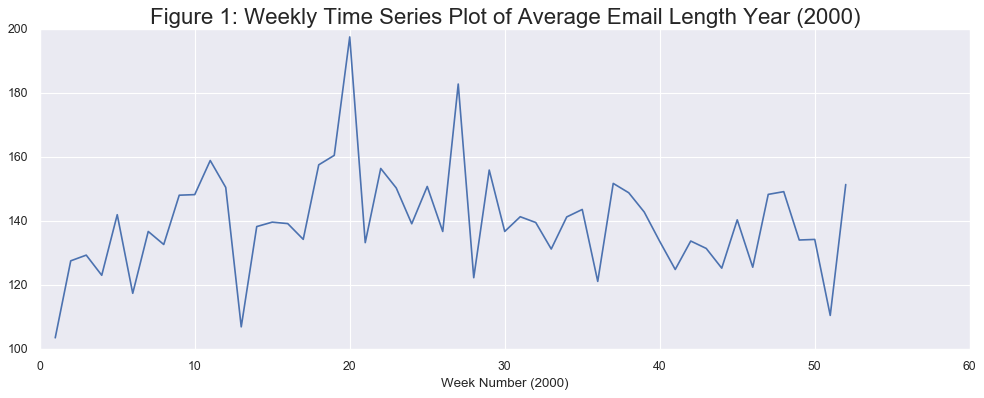

In [12]:
plt.figure(figsize=(15,5))
plt.plot(a1)
plt.title("Figure 1: Weekly Time Series Plot of Average Email Length Year (2000)",fontsize=20)
plt.xlabel("Week Number (2000)")

Text(0.5, 0, 'Week Number (2001)')

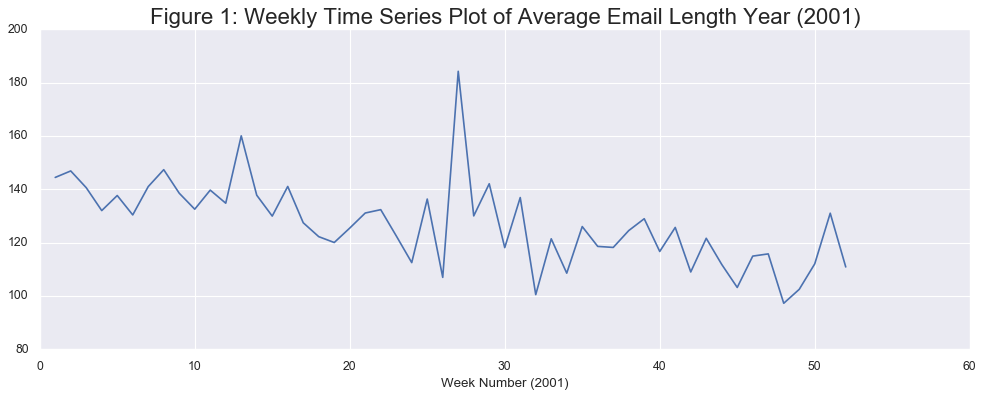

In [13]:
plt.figure(figsize=(15,5))
plt.plot(a2)
plt.title("Figure 1: Weekly Time Series Plot of Average Email Length Year (2001)",fontsize=20)
plt.xlabel("Week Number (2001)")

In [14]:
weeks, windows = get_weeks_windows()


In [15]:
sents , dis = get_weekly_sent_dis(windows,df)

In [16]:
# making the windows for 13 weeks
# moving average

sentiment = pd.DataFrame(sents).rolling(window=13).mean()
disagreement = pd.DataFrame(dis).rolling(window=13).mean()

Text(0, 0.5, 'Net Sentiment')

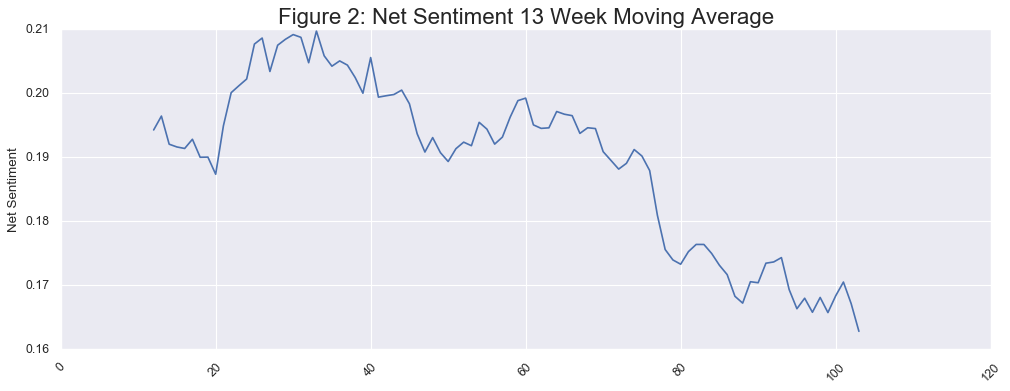

In [17]:
plt.figure(figsize=(15,5))
plt.title("Figure 2: Net Sentiment 13 Week Moving Average",fontsize=20)
plt.plot(sentiment)
plt.xticks(rotation=45)
plt.ylabel("Net Sentiment")

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 7 Text xticklabel objects>)

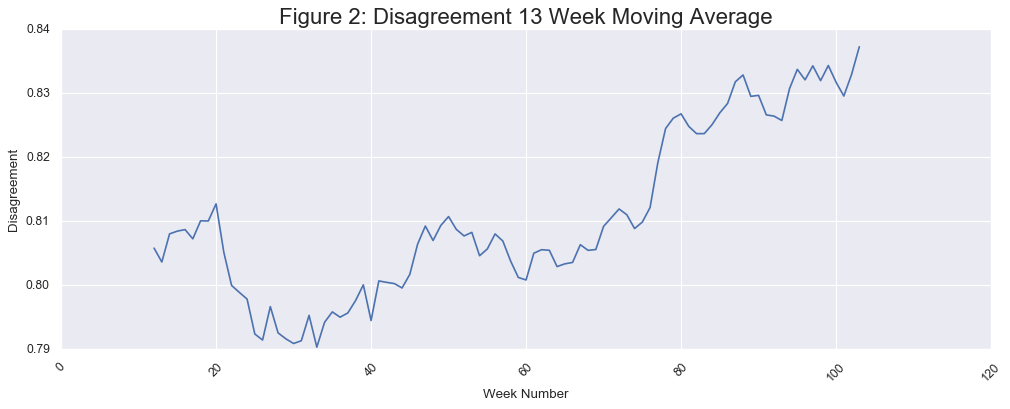

In [18]:
plt.figure(figsize=(15,5))
plt.title("Figure 2: Disagreement 13 Week Moving Average",fontsize=20)
plt.plot(disagreement)
plt.ylabel("Disagreement")
plt.xlabel("Week Number")
plt.xticks(rotation=45)

In [19]:
# loading the articles
df_a = pd.DataFrame(articles_list)
df_a = df_a.sort_values("Date")

weeks , windows = get_weeks_windows()
# creating the new column
df_a["Week"] = df_a["Date"].apply(get_week_number,windows=windows)

In [20]:
df_a

,Header,Body,Date,Week
1441,Book Details Political Donors,donor. One of Vinson & Elkins' clients is the...,2000-01-05,1
1041,Book details biggest donors to presidential ca...,"they gave $92,600 through Sept. 30, seventh m...",2000-01-05,1
1418,UI Completes Standard Offer Agreement,"Enron North America , ""UI's customers are assu...",2000-01-10,1
2191,UI Completes Standard Offer Agreement,"Enron North America , ""UI's customers are assu...",2000-01-10,1
1452,Network Vendors and Service Providers Form Coa...,"Enron Communications, Inc. www.ec.enron.com ...",2000-01-12,2
...,...,...,...,...
569,AEP acquires Texas wind-power project from Enron,"wind farm, the 150-megawatt Trent Mesa Wind P...",2001-12-31,104
1738,No Headline In Original,Enron 's credit ratings healthy so it could ob...,2001-12-31,104
971,Enron denies money tied to probe,Enron 's money be given to a charitable organi...,2001-12-31,104
394,Enron creditor seeks to block insurers' reques...,into the federal bankruptcy court proceedings...,2001-12-31,104


Text(0.5, 0, 'Week Number')

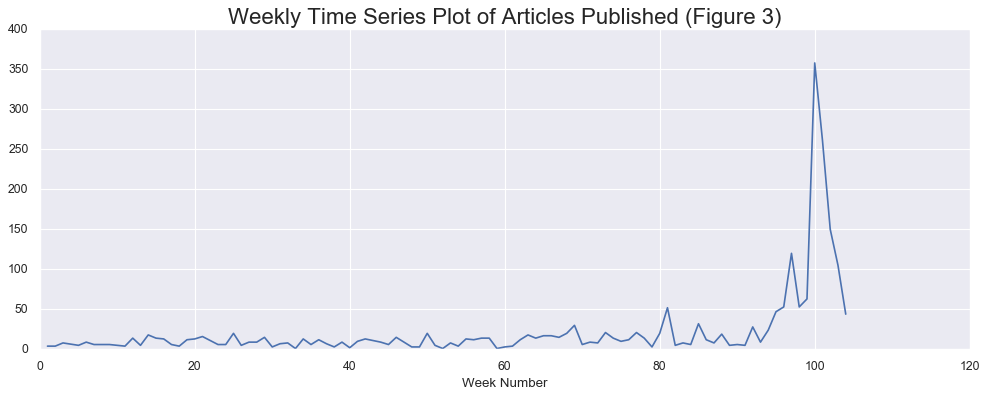

In [21]:
plt.figure(figsize=(15,5))
plt.plot(df_a.groupby("Week").count()["Date"])
plt.title("Weekly Time Series Plot of Articles Published (Figure 3)",fontsize=20)
plt.xlabel("Week Number")

In [22]:
# creating new sentiment columns for body and header
df_a["Body"] = df_a["Body"].str.lower()
df_a["Header"] = df_a["Header"].str.lower()
df_a["Sent_Body"] = df_a["Body"].apply(get_net_sentiment)
df_a["Sent_Header"] = df_a["Header"].apply(get_net_sentiment)

In [23]:
df_sent = df_a.groupby("Week").agg({"Sent_Body":"mean","Sent_Header":"mean"})

In [24]:
# calculating the 13-week moving averages

moving_avg_body = df_sent["Sent_Body"].rolling(window=13).mean()
moving_avg_header = df_sent["Sent_Header"].rolling(window=13).mean()

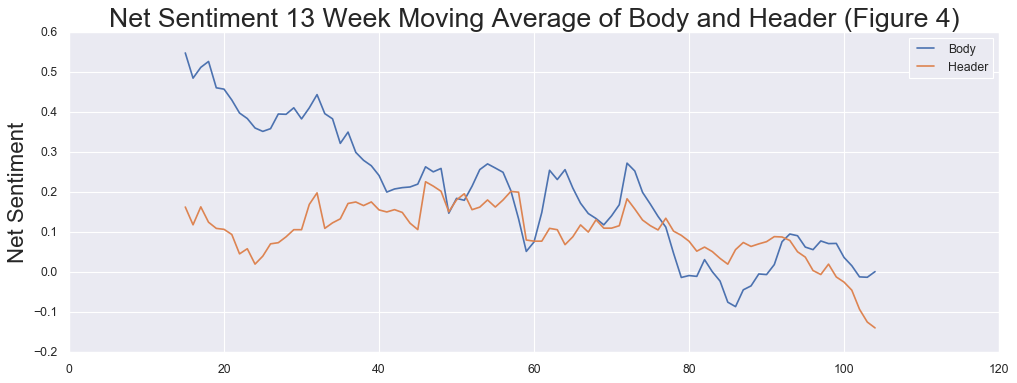

In [25]:
plt.figure(figsize=(15,5))
plt.title("Net Sentiment 13 Week Moving Average of Body and Header (Figure 4)",fontsize=24)
plt.plot(moving_avg_body)
plt.plot(moving_avg_header)
plt.ylabel("Net Sentiment",fontsize=20)
plt.legend(["Body","Header"])

In [26]:
# creating dataframe of emails
mails_list = []
for i in emails.items():
    for j in i[1]:
        mails_list.append(j)
        
df = pd.DataFrame(mails_list)

# sort by date
df = pd.DataFrame(mails_list)
df.sort_values("date",inplace=True)
df['week'] = df["date"].apply(get_week_number,windows=windows)
df['char'] = df["message"].apply(get_characters)
df['net_sentiment'] = df["message"].apply(get_net_sentiment)

In [27]:
sents , dis = get_weekly_sent_dis(windows,df)

In [28]:
sents = pd.DataFrame(sents)
moving_avg_sent = sents.rolling(window=13).mean()

In [29]:
stock = pd.read_excel("enronstockchart.xlsx")
stock = stock.sort_values("Date")
stock["Date"] = pd.to_datetime(stock["Date"])
stock = stock[stock["Date"] >= "2000-01-03"]
stock["Return"] = stock["Close"].pct_change()
stock["Week"] = stock["Date"].apply(get_week_number,windows=windows)
weekly_return = stock.groupby("Week").agg({"Return":"mean"})
moving_avg_return = weekly_return.rolling(window=13).mean()

Text(0, 0.5, 'Stock Returns')

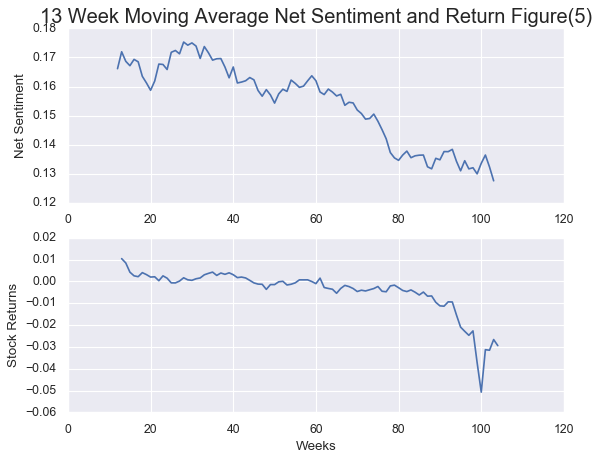

In [30]:
plt.subplot(2, 1, 1)
plt.plot(moving_avg_sent)
plt.title('13 Week Moving Average Net Sentiment and Return Figure(5)',fontsize=18)
plt.ylabel('Net Sentiment')

plt.subplot(2, 1, 2)
plt.plot(moving_avg_return)
plt.xlabel('Weeks')
plt.ylabel('Stock Returns')

In [31]:
# mean of the closing price weekly
stock_prices = stock.groupby("Week").agg({"Close":"mean"})
moving_avg_prices = stock_prices["Close"].rolling(window=13).mean()

Text(0, 0.5, 'Stock Prices')

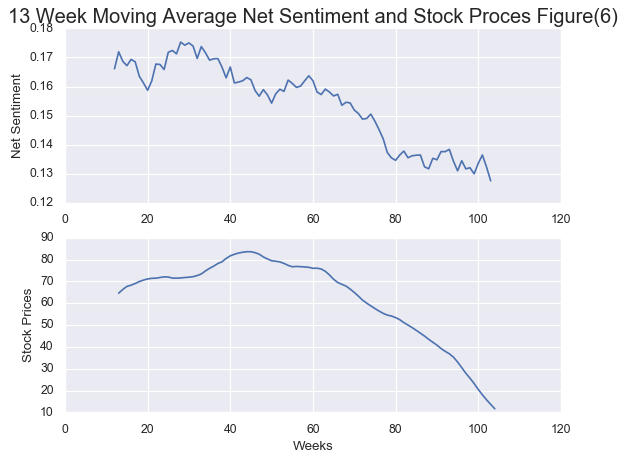

In [32]:
plt.subplot(2, 1, 1)
plt.plot(moving_avg_sent)
plt.title('13 Week Moving Average Net Sentiment and Stock Proces Figure(6)',fontsize=18)
plt.ylabel('Net Sentiment')

plt.subplot(2, 1, 2)
plt.plot(moving_avg_prices)
plt.xlabel('Weeks')
plt.ylabel('Stock Prices')

In [33]:
df["week"] = df["date"].apply(get_week_number,windows=windows)
weekly_char = df.groupby("week").agg({"char":"mean"})["char"]
moving_avg_char = weekly_char.rolling(window=13).mean()

Text(0, 0.5, 'Stock Returns')

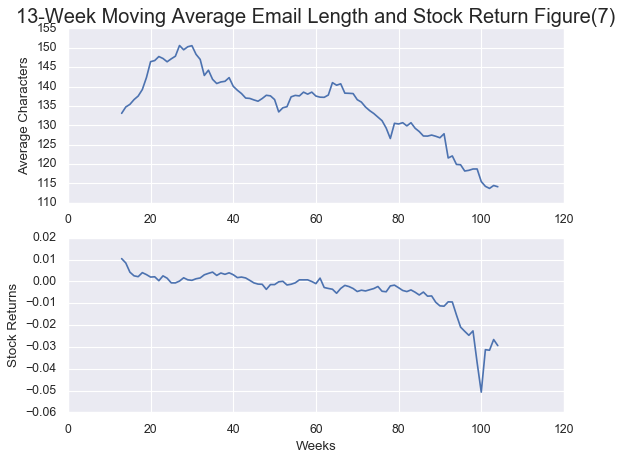

In [34]:
plt.subplot(2, 1, 1)
plt.plot(moving_avg_char)
plt.title('13-Week Moving Average Email Length and Stock Return Figure(7)',fontsize=18)
plt.ylabel('Average Characters')

plt.subplot(2, 1, 2)
plt.plot(moving_avg_return)
plt.xlabel('Weeks')
plt.ylabel('Stock Returns')

Text(0, 0.5, 'Stock Price')

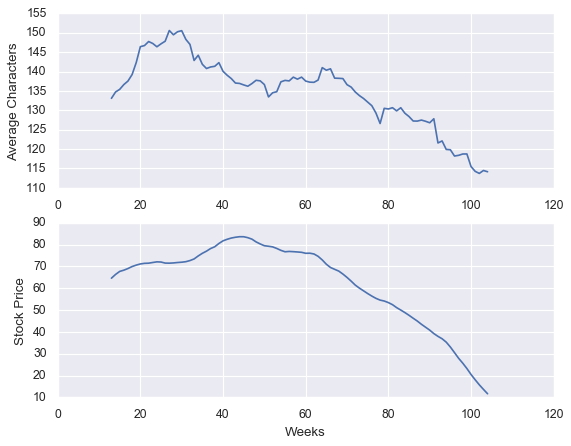

In [35]:
plt.subplot(2, 1, 1)
plt.plot(moving_avg_char)

plt.ylabel('Average Characters')

plt.subplot(2, 1, 2)
plt.plot(moving_avg_prices)
plt.xlabel('Weeks')
plt.ylabel('Stock Price')

In [36]:
# 13-week moving average of total emails 
total_emails = df.groupby("week").count()["recipient"]
moving_total_emails = pd.DataFrame(total_emails).rolling(window=13).mean()

In [37]:
# 13-week moving average of net setiment
avg_sent = df.groupby("week").agg({"net_sentiment":"mean"})["net_sentiment"]
moving_avg_sent = avg_sent.rolling(window=13).mean()

In [38]:
df_reg = pd.DataFrame() 
# creating columns 
df_reg["MA_Email_Sentiment"] =  moving_avg_sent.dropna()
df_reg["MA_Email_Length"] = moving_avg_char.dropna()
df_reg["MA_Total_Emails"] = moving_total_emails.dropna()
df_reg["MA_Returns"] = moving_avg_return.dropna()

In [39]:
# scaling the values from 0 to 1 for the regression to work
scaler = MinMaxScaler()
scaler.fit(df_reg["MA_Returns"].values.reshape(-1,1))
df_reg["MA_Returns"] =scaler.transform(df_reg["MA_Returns"].values.reshape(-1,1)).reshape(1,-1)[0]

In [40]:
scaler = MinMaxScaler()
scaler.fit(df_reg["MA_Total_Emails"].values.reshape(-1,1))
df_reg["MA_Total_Emails"] =scaler.transform(df_reg["MA_Total_Emails"].values.reshape(-1,1)).reshape(1,-1)[0]

In [41]:
scaler = MinMaxScaler()
scaler.fit(df_reg["MA_Email_Length"].values.reshape(-1,1))
df_reg["MA_Email_Length"] =scaler.transform(df_reg["MA_Email_Length"].values.reshape(-1,1)).reshape(1,-1)[0]

In [42]:
scaler = MinMaxScaler()
scaler.fit(df_reg["MA_Email_Sentiment"].values.reshape(-1,1))
df_reg["MA_Email_Sentiment"] =scaler.transform(df_reg["MA_Email_Sentiment"].values.reshape(-1,1)).reshape(1,-1)[0]

In [43]:
est = sm.OLS(df_reg["MA_Returns"],df_reg.drop("MA_Returns",axis=1))
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:             MA_Returns   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              541.5
Date:                Tue, 14 Apr 2020   Prob (F-statistic):                    5.10e-57
Time:                        09:50:21   Log-Likelihood:                          28.810
No. Observations:                  92   AIC:                                     -51.62
Df Residuals:                      89   BIC:                                     -44.05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [44]:
df_reg["MA_Body_Sentiment"] = moving_avg_body

In [45]:
scaler = MinMaxScaler()
scaler.fit(df_reg["MA_Body_Sentiment"].values.reshape(-1,1))
df_reg["MA_Body_Sentiment"] =scaler.transform(df_reg["MA_Body_Sentiment"].values.reshape(-1,1)).reshape(1,-1)[0]

In [46]:
# training with new set of features
df_reg = df_reg.dropna()
est = sm.OLS(df_reg["MA_Returns"],df_reg.drop("MA_Returns",axis=1))
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:             MA_Returns   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              454.6
Date:                Tue, 14 Apr 2020   Prob (F-statistic):                    5.97e-57
Time:                        09:50:21   Log-Likelihood:                          35.091
No. Observations:                  90   AIC:                                     -62.18
Df Residuals:                      86   BIC:                                     -52.18
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [47]:
df_reg.drop("MA_Body_Sentiment",axis=1,inplace=True)

In [48]:
df_reg["MA_Header_Sentiment"] = moving_avg_header

In [49]:
scaler = MinMaxScaler()
scaler.fit(df_reg["MA_Header_Sentiment"].values.reshape(-1,1))
df_reg["MA_Header_Sentiment"] =scaler.transform(df_reg["MA_Header_Sentiment"].values.reshape(-1,1)).reshape(1,-1)[0]

In [50]:
# training with new set of features
df_reg = df_reg.dropna()
est = sm.OLS(df_reg["MA_Returns"],df_reg.drop("MA_Returns",axis=1))
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:             MA_Returns   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              994.2
Date:                Tue, 14 Apr 2020   Prob (F-statistic):                    4.34e-71
Time:                        09:50:21   Log-Likelihood:                          69.185
No. Observations:                  90   AIC:                                     -130.4
Df Residuals:                      86   BIC:                                     -120.4
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [51]:
df_reg["MA_Body_Sentiment"] = moving_avg_body
df_reg["MA_Header_Sentiment"] = moving_avg_header
df_reg = df_reg.dropna()

Text(0.5, 1.0, 'Correlation between Email Sentiment and News Body Sentiment (Figure 9)')

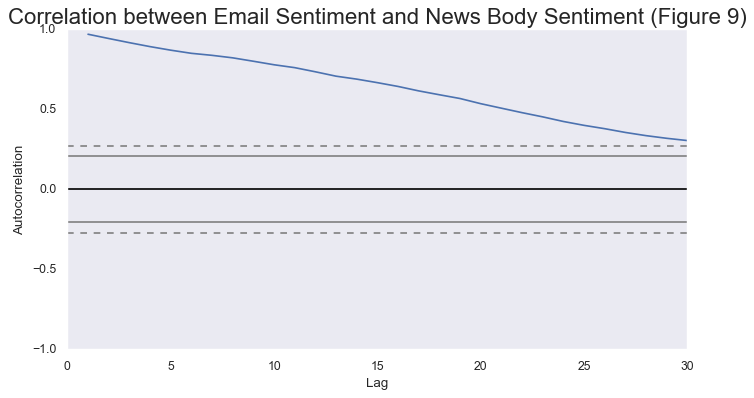

In [52]:
plt.figure(figsize=(10,5))
pd.plotting.autocorrelation_plot(df_reg[["MA_Email_Sentiment","MA_Body_Sentiment"]]).set_xlim([0, 30])
plt.title("Correlation between Email Sentiment and News Body Sentiment (Figure 9)",fontsize=20)

Text(0.5, 1.0, 'Correlation between Email Sentiment and News Header Sentiment (Figure 9)')

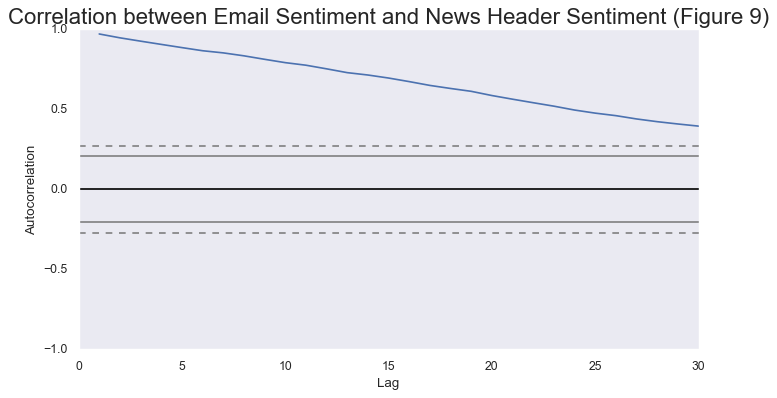

In [53]:
plt.figure(figsize=(10,5))
pd.plotting.autocorrelation_plot(df_reg[["MA_Email_Sentiment","MA_Header_Sentiment"]]).set_xlim([0, 30])
plt.title("Correlation between Email Sentiment and News Header Sentiment (Figure 9)",fontsize=20)

In [54]:
nodes = list(emails.keys())

In [55]:
# creating the dictionary of all the email address for each employee
address_dict = {}
for i in nodes:
    person_mails = emails[i]
    
    if len(person_mails) != 0:
        address = person_mails[0]['sender']
        address_dict[address] = i

In [56]:
# saving the connections between employees for year 2000
connections_1 = []

d1 = datetime.datetime.strptime("2000-01-01",'%Y-%m-%d') 
d2 = datetime.datetime.strptime("2001-01-01",'%Y-%m-%d') 

for i in emails.items():
    person_connections = []
    for mail in i[1]:
        if mail["date"] >= d1 and mail["date"] < d2: 
            for rec in mail['recipient']:
                try:
                    person_connections.append(address_dict[rec])
                except:
#                    print("Error",rec)
                    pass
    
    person_connections = set(person_connections)
    
    for con in person_connections:
        connections_1.append((i[0],con))

connections_1 = [(x.replace("/Users/hendrik/Desktop/CRAM_Project/Code/enron/",""),
                  y.replace("/Users/hendrik/Desktop/CRAM_Project/Code/enron/","")) 
                 for x, y in connections_1]

In [57]:
# making the graph of the connections
interactome = nx.Graph(connections_1)

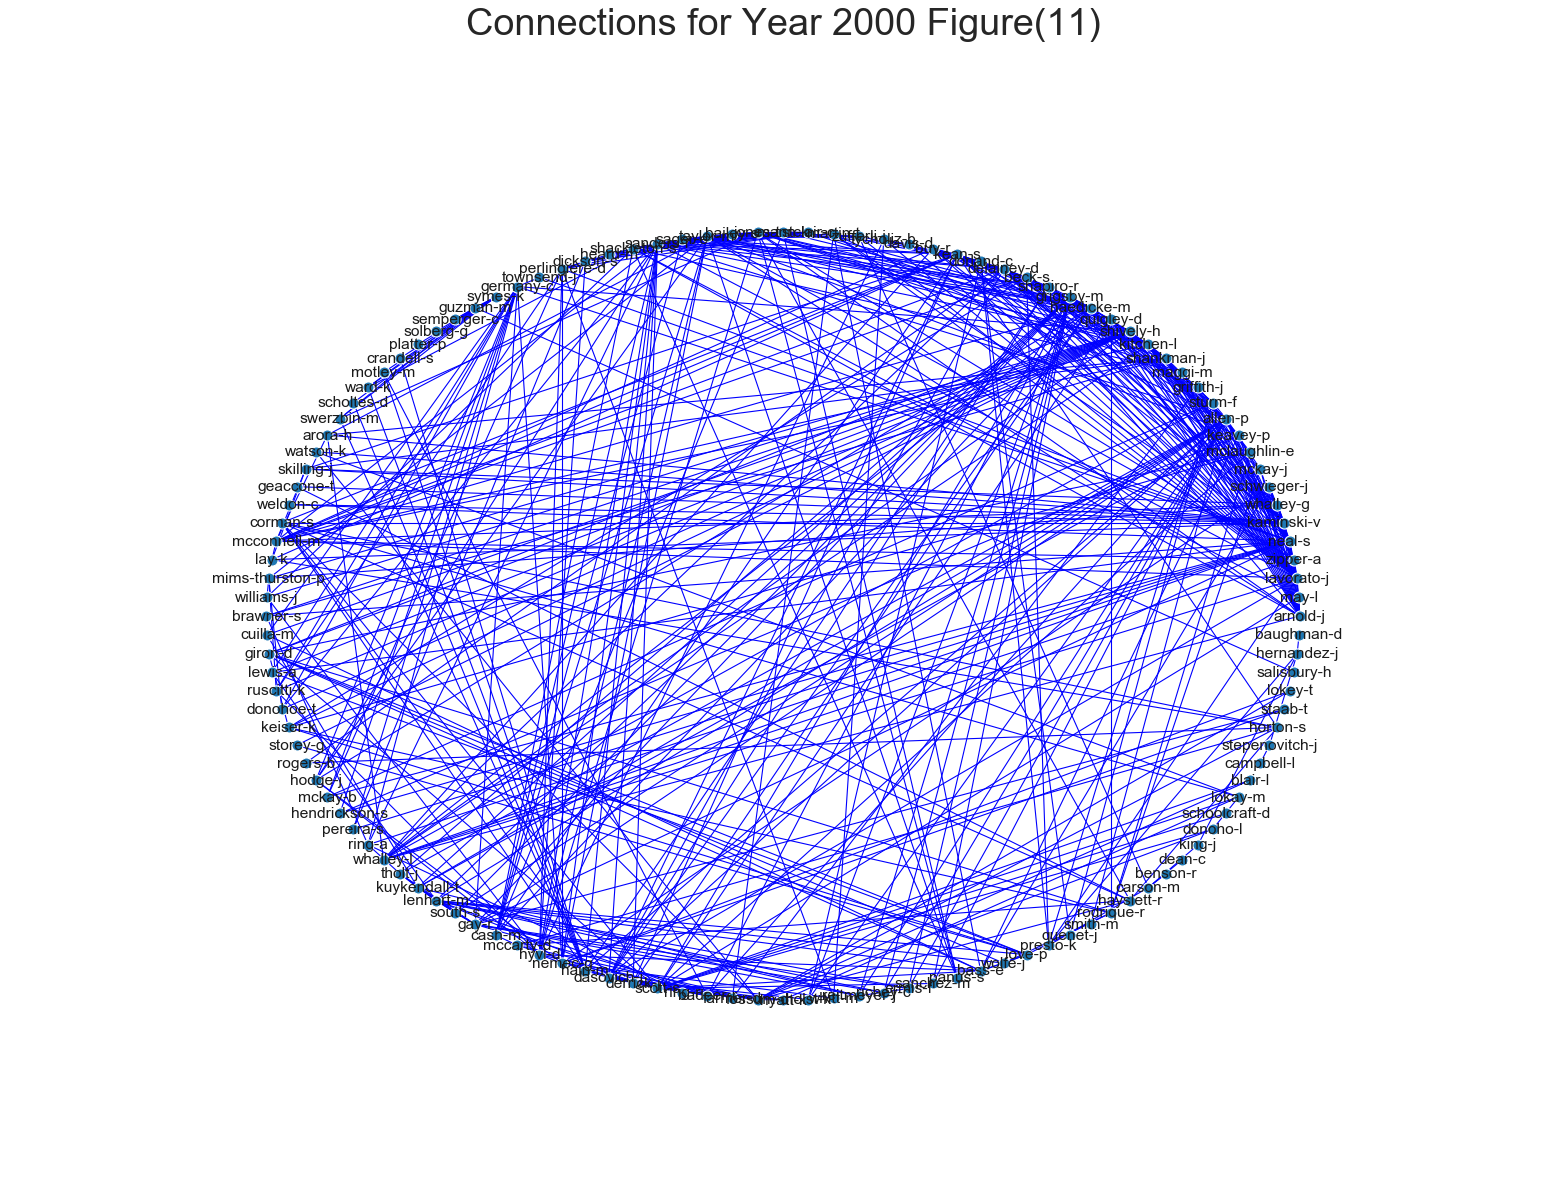

In [58]:
plt.figure(figsize=(25, 18))
plt.title("Connections for Year 2000 Figure(11)",fontsize=34)
nx.draw_shell(interactome,with_labels = True,node_size=100,font_size=14,edge_color="blue")

In [59]:
# saving the connections of employees for year 2001 
connections_2 = []

d1 = datetime.datetime.strptime("2001-01-01",'%Y-%m-%d') 
d2 = datetime.datetime.strptime("2002-01-01",'%Y-%m-%d') 

for i in emails.items():
    person_connections = []
    for mail in i[1]:
        if mail["date"] >= d1 and mail["date"] < d2: 
            for rec in mail['recipient']:
                try:
                    person_connections.append(address_dict[rec])
                except:
    #                 print("Error",rec)
                    pass
    person_connections = set(person_connections)
    for con in person_connections:
        connections_2.append((i[0],con))
        
connections_2 = [(x.replace("/Users/hendrik/Desktop/CRAM_Project/Code/enron/",""),
                  y.replace("/Users/hendrik/Desktop/CRAM_Project/Code/enron/","")) 
                 for x, y in connections_2]

In [60]:
interactome_2 = nx.Graph(connections_2)

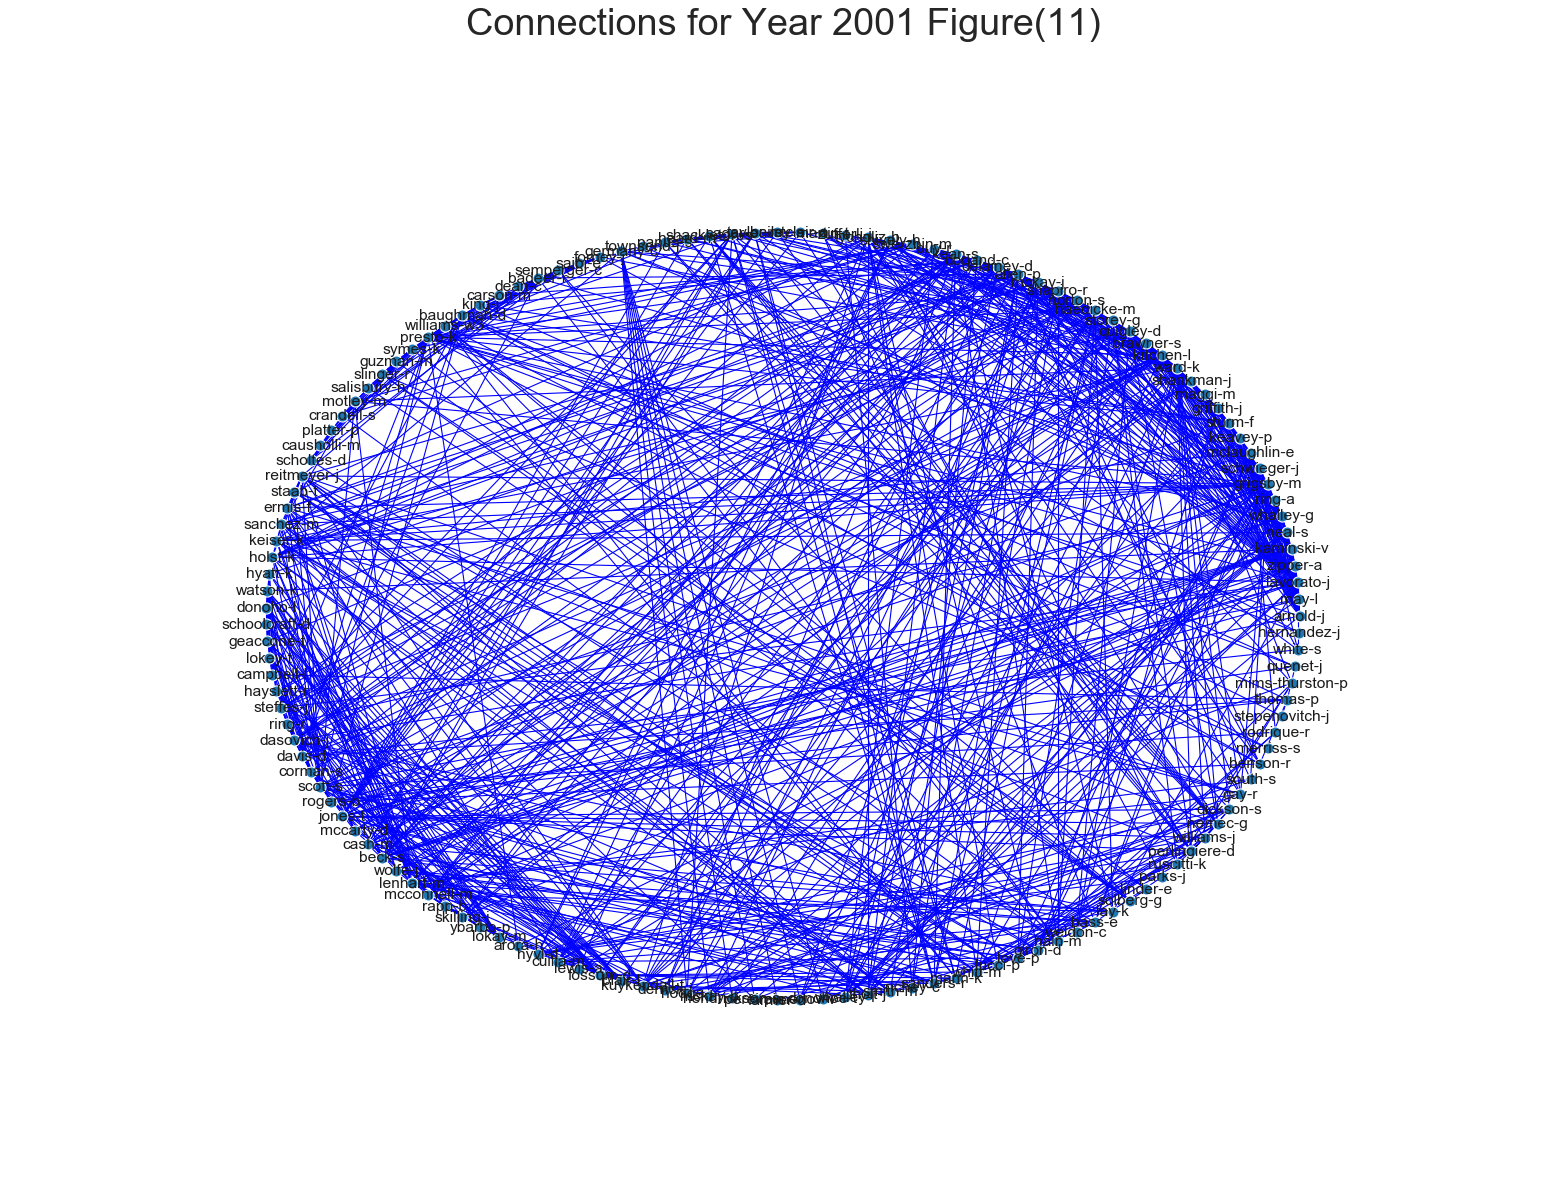

In [61]:
plt.figure(figsize=(25, 18))
plt.title("Connections for Year 2001 Figure(11)",fontsize=34)
nx.draw_shell(interactome_2,with_labels = True,node_size=100,font_size=14,edge_color="blue")

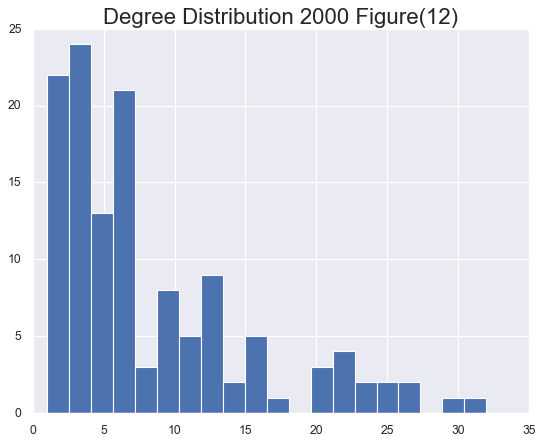

In [62]:
degrees = dict(interactome.degree)

plt.hist(degrees.values(),bins=20)
plt.title("Degree Distribution 2000 Figure(12)",fontsize=20)
plt.show()

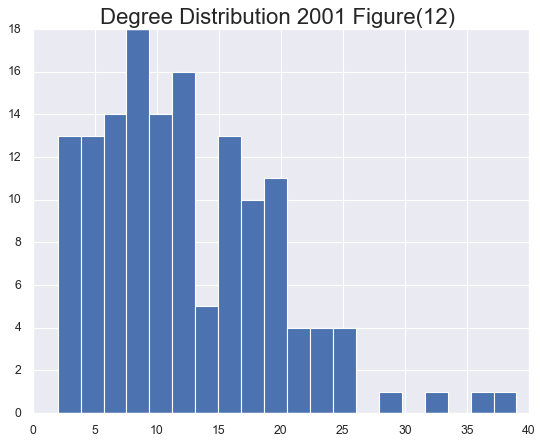

In [63]:
degrees = dict(interactome_2.degree)

plt.hist(degrees.values(),bins=20)
plt.title("Degree Distribution 2001 Figure(12) ",fontsize=20)
plt.show()

In [64]:
def get_word_count(msg,words):
    '''
    Returns the count of the given word in the message body
    '''
    count = 0
    msg = msg.lower().split()
    for w in msg:
        w = w.strip()
        if w in words:
            count += 1
    return count
    

In [84]:
df["word_loss"] = df["message"].apply(get_word_count,words=["losses"])

In [85]:
df["word_profit"] = df["message"].apply(get_word_count,words=["profits"])

In [86]:
los_ser = df.groupby("week").agg({'word_loss':"mean"})["word_loss"]
los_ser = pd.DataFrame(los_ser).rolling(window=13).mean()

In [87]:
profit_ser = df.groupby("week").agg({'word_profit':"mean"})["word_profit"]
profit_ser = pd.DataFrame(profit_ser).rolling(window=13).mean()

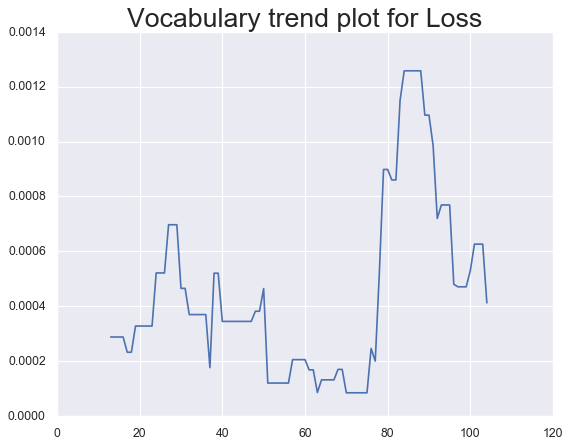

In [88]:
plt.title("Vocabulary trend plot for Loss",fontsize=24)
plt.plot(los_ser)


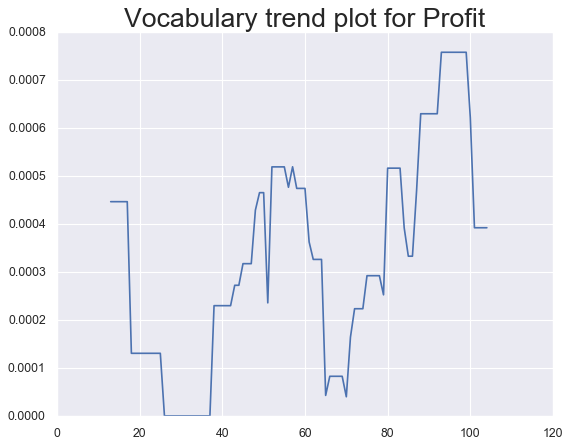

In [89]:
plt.title("Vocabulary trend plot for Profit",fontsize=24)
plt.plot(profit_ser)

In [71]:
parser = English()

In [72]:
def get_lemma(word):
    '''
    Returns the word after lemmatizing 
    '''
    return WordNetLemmatizer().lemmatize(word)

In [73]:
translator = str.maketrans("","",string.punctuation)

from nltk import pos_tag

def process_text(text):
    '''
    Returns the nouns and adjectives from the message after removing the punctuations
    and stop words and lemmatizing
    '''
    tokens = []
    text = text.translate(translator)
    for i in parser(text):
        i = str(i)
        i = i.strip()
        if i != "": 
            tokens.append(i)
            
    tokens = [token for token in tokens if len(token) >= 3]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    
    n_j = []
    for tag in pos_tag(tokens):
#         print(tag[1])
        if tag[1] == "NN" or tag[1] == "JJ":
#             print("ran",tag[0])
            w = tag[0]
#             print(w)
            n_j.append(w)
            
    return n_j

In [74]:
# create the list of nouns and adjectives of all the emails
text_data = []

for msg in df_a["Body"].values:
    nj = process_text(msg)
    text_data.append(nj)

In [75]:
from gensim import corpora
# bag of words
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]


In [76]:
# saving the corpus
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [77]:
import gensim
NUM_TOPICS = 5
#creating the lda model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# saving the model
ldamodel.save('model5.gensim')

In [78]:
# printing the top 5 words of each topic to get the idea of each topic
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.056*"enron" + 0.038*"service" + 0.015*"broadband" + 0.013*"corp" + 0.013*"company"')
(1, '0.094*"enron" + 0.026*"company" + 0.026*"stock" + 0.021*"employee" + 0.013*"plan"')
(2, '0.070*"enron" + 0.029*"exposure" + 0.026*"corp" + 0.016*"power" + 0.016*"company"')
(3, '0.086*"enron" + 0.018*"company" + 0.016*"energy" + 0.012*"dynegy" + 0.012*"stock"')
(4, '0.099*"enron" + 0.018*"company" + 0.016*"energy" + 0.015*"bankruptcy" + 0.012*"trading"')


In [79]:
df_1 = df_a[df_a["Date"].dt.year == 2000]
df_2 = df_a[df_a["Date"].dt.year == 2001]

In [80]:
df_1["month"] = df_1["Date"].dt.month
df_2["month"] = df_2["Date"].dt.month

/Users/hendrik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/hendrik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
# creating a list of all the words for each month
monthly = []
for i in df_1.groupby("month"):
    month_words = i[1]['Body'].apply(process_text).to_list()
    monthly.append(month_words)
    
for i in df_2.groupby("month"):
    month_words = i[1]['Body'].apply(process_text).to_list()
    monthly.append(month_words)

In [82]:
# checking the degree of each topic in each month and saving into a list
topics = []
for month in monthly:
    words = [item for sublist in month for item in sublist]
    new_doc_bow = dictionary.doc2bow(words)
#     print(new_doc_bow)
    topics.append([i[1] for i in ldamodel.get_document_topics(new_doc_bow)])

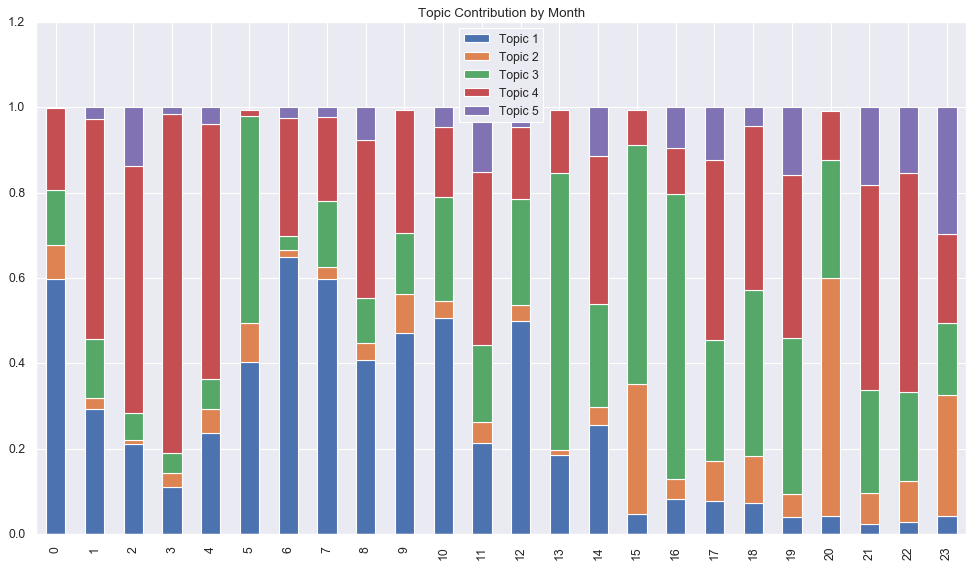

In [83]:

pd.DataFrame(topics,columns=["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5"]) \
  .plot(kind="bar",stacked=True,figsize=(15,8),title="Topic Contribution by Month")